In [1]:
#!pip install geopy
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from geopy.distance import geodesic
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,PowerTransformer,Normalizer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, ElasticNet,Lasso
from sklearn.neighbors import KNeighborsRegressor


# Exploration des données


## Nettoyage des données

In [2]:
df = pd.read_csv('housing.csv')

<div style='background-color:lightgreen; font-style:italic;'> On supprime la colonne Unamed,  les NA dans le df et la catégorie ISLAND dans la colonne ocean_proximity</div>

In [3]:
df=df.drop('Unnamed: 0',axis=1)
df = df.dropna(subset=['total_bedrooms'])
#df.isna().sum()

In [4]:
df=df.drop(df[df['ocean_proximity'] == 'ISLAND'].index)
df['ocean_proximity'].unique()

array(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY'], dtype=object)

In [5]:
df.drop(df[df['households'] > df['population']].index, inplace=True)

In [6]:
#df.sort_values(by='total_bedrooms')

## Detections des abberations

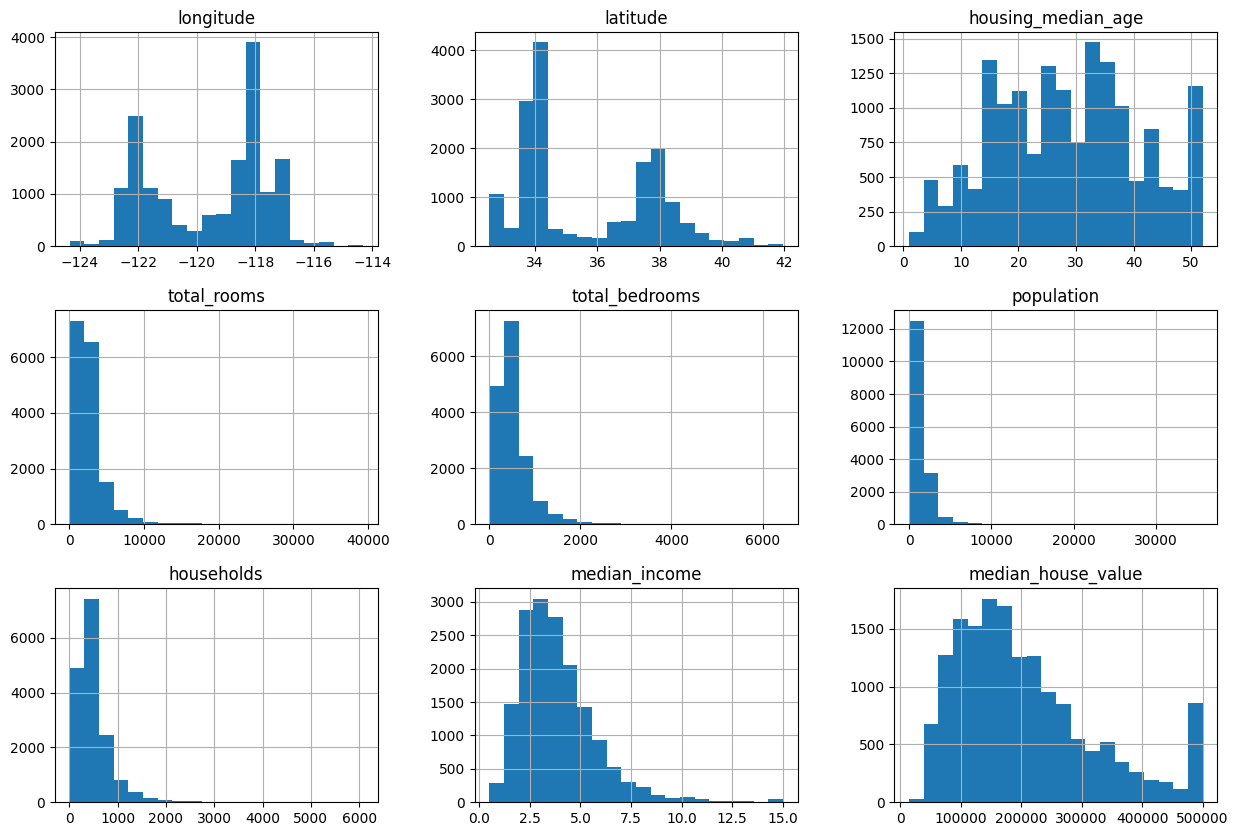

In [7]:
# Utiliser des histogrammes pour visualiser les distributions
df.hist(bins=20, figsize=(15,10))
plt.show()

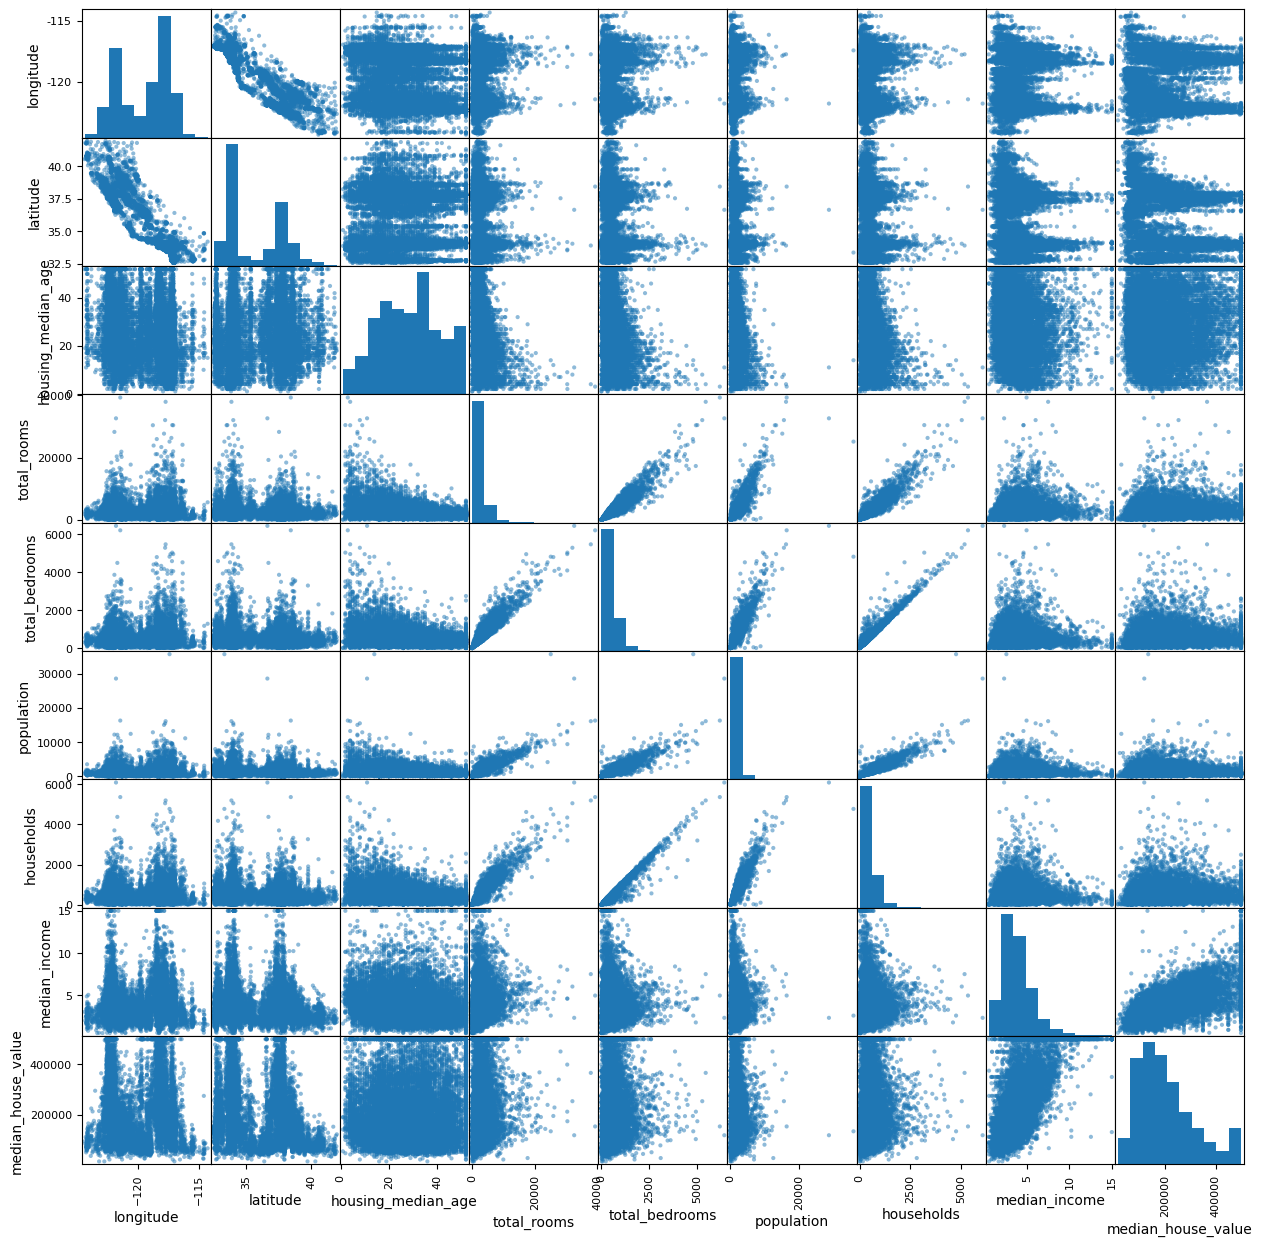

In [8]:
pd.plotting.scatter_matrix(df, figsize=(15, 15))
plt.show()

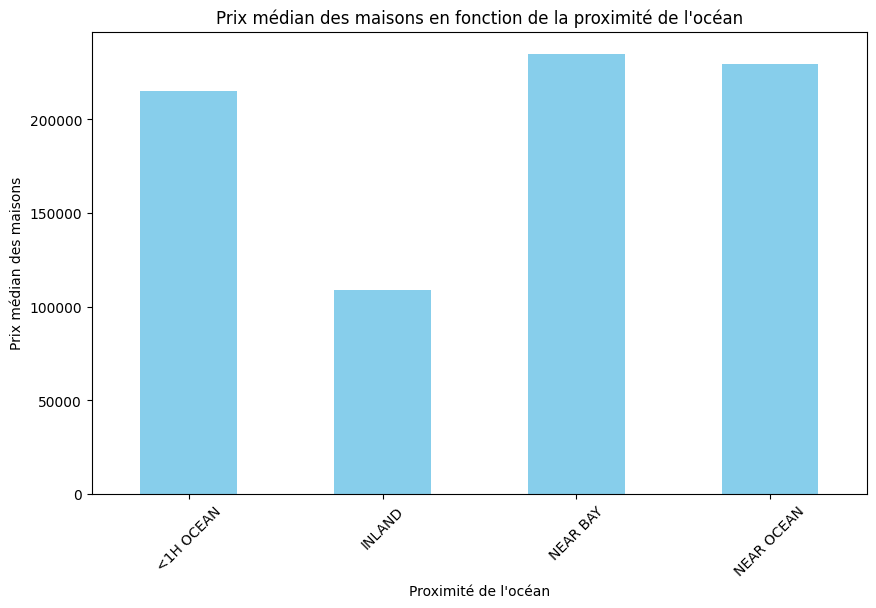

In [9]:

# Calculer la valeur médiane des maisons pour chaque catégorie de proximité de l'océan
median_house_value_by_ocean = df.groupby('ocean_proximity')['median_house_value'].median()

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
median_house_value_by_ocean.plot(kind='bar', color='skyblue')

# Ajouter des titres et des légendes
plt.title('Prix médian des maisons en fonction de la proximité de l\'océan')
plt.xlabel('Proximité de l\'océan')
plt.ylabel('Prix médian des maisons')
plt.xticks(rotation=45)  # Rotation des étiquettes sur l'axe x pour une meilleure lisibilité

# Afficher le graphique
plt.show()


In [10]:
df['is_inland'] = (df['ocean_proximity'] == 'INLAND').astype(int)
df.drop(['ocean_proximity'], axis=1, inplace=True)

### Premier filtre

<div style='background-color:lightblue; font-style:italic;'>Détection des valeurs aberrantes : Identifiez les valeurs qui se situent loin de la moyenne ou des quartiles de la distribution. Vous pouvez utiliser des méthodes statistiques comme les méthodes basées sur l'écart interquartile (IQR) ou basées sur l'écart absolu médian (MAD). </div>

In [11]:
df_clean=df

Cette méthode ci dessous ne fonctionne pas, baisse de 3% du R²

#### Visualisation du premier filtre

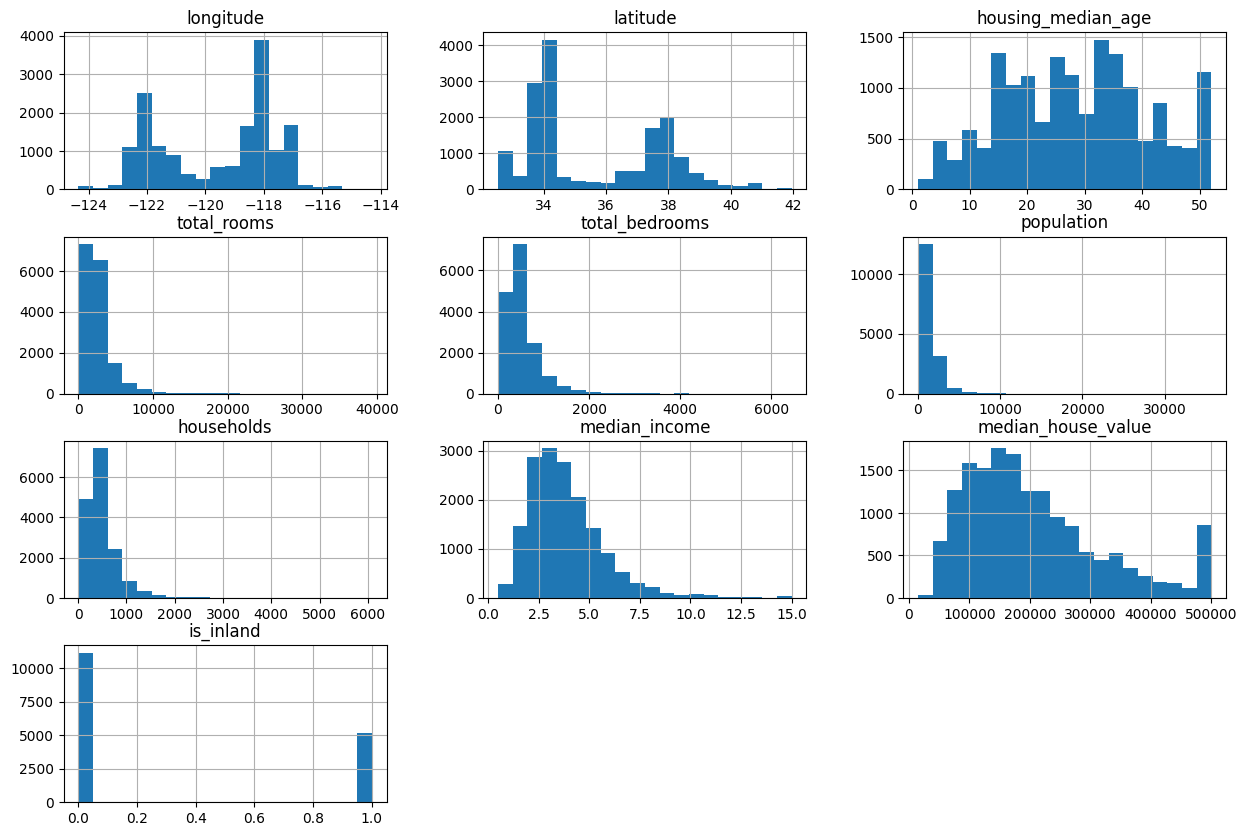

In [12]:
df_clean.hist(bins=20, figsize=(15,10))
plt.show()

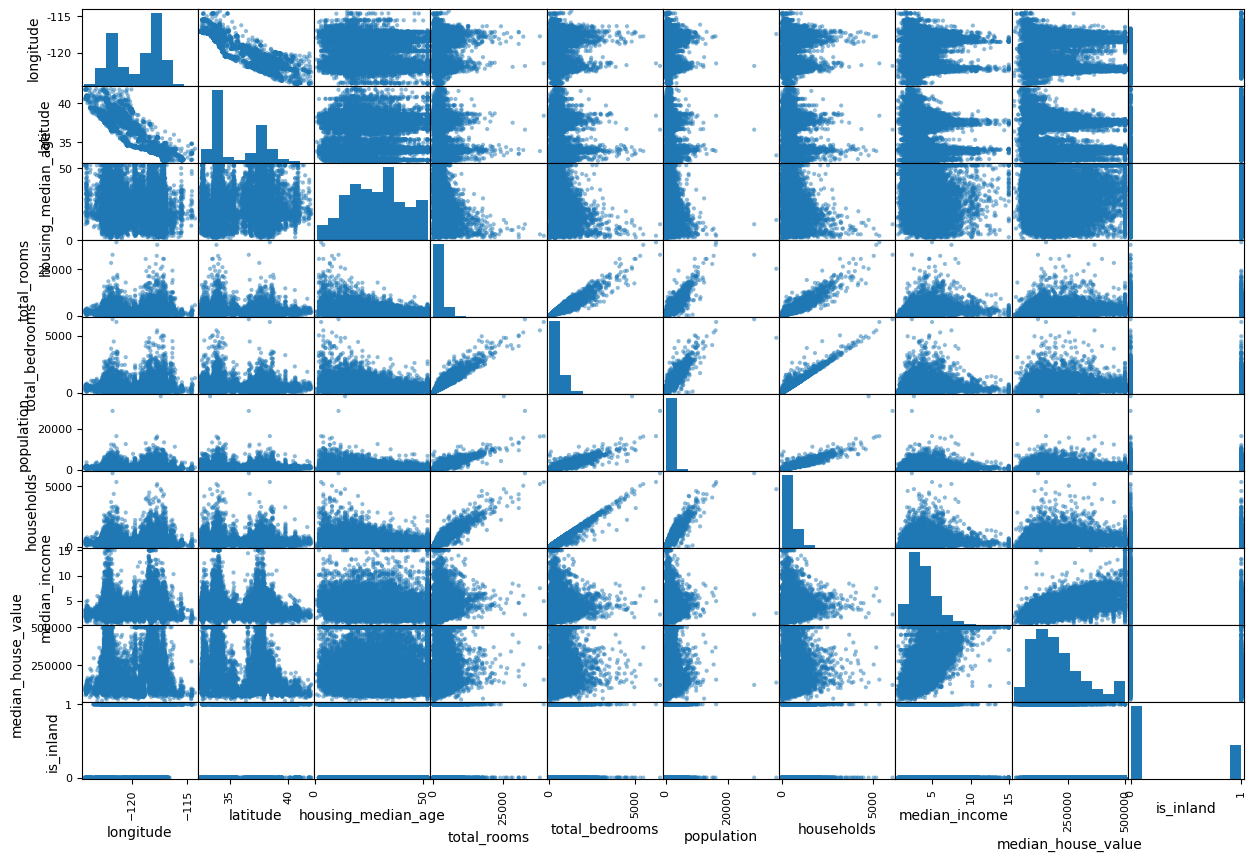

In [13]:
scatter_matrix(df_clean, figsize=(15, 10))
plt.show()

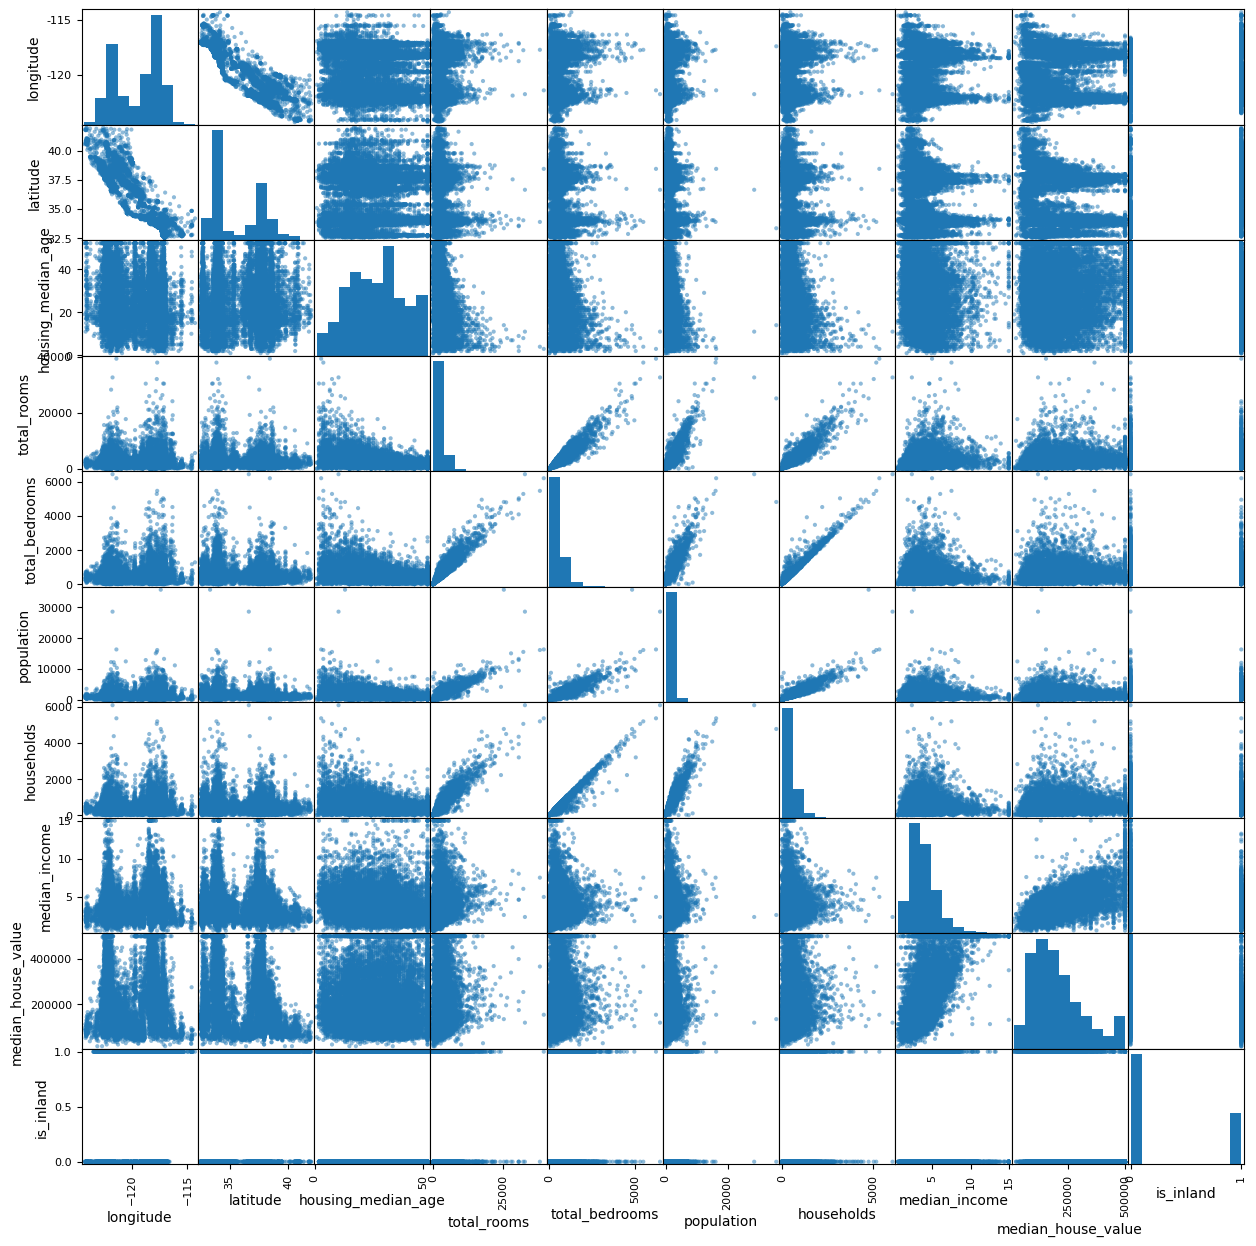

In [14]:
pd.plotting.scatter_matrix(df, figsize=(15, 15))
plt.show()

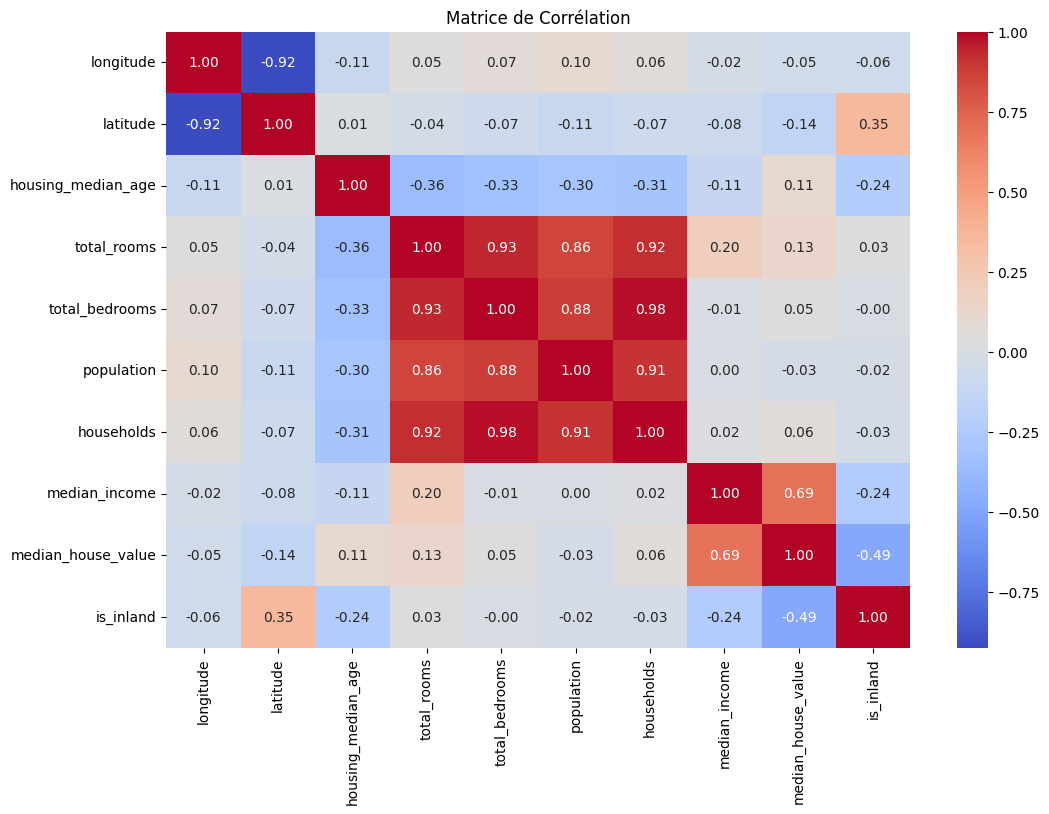

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,is_inland
longitude,1.000000,-0.924784,-0.111356,0.045306,0.069668,0.100084,0.056576,-0.020088,-0.046794,-0.055229
latitude,-0.924784,1.000000,0.011911,-0.035251,-0.065241,-0.106367,-0.069406,-0.076196,-0.143619,0.351057
housing_median_age,-0.111356,0.011911,1.000000,-0.361569,-0.325031,-0.295425,-0.307442,-0.112885,0.109310,-0.240436
total_rooms,0.045306,-0.035251,-0.361569,1.000000,0.932405,0.855889,0.920819,0.198602,0.132868,0.028407
total_bedrooms,0.069668,-0.065241,-0.325031,0.932405,1.000000,0.878586,0.980012,-0.005834,0.047629,-0.002562
population,0.100084,-0.106367,-0.295425,0.855889,0.878586,1.000000,0.907505,0.004447,-0.027774,-0.015444
households,0.056576,-0.069406,-0.307442,0.920819,0.980012,0.907505,1.000000,0.015130,0.062951,-0.033751
median_income,-0.020088,-0.076196,-0.112885,0.198602,-0.005834,0.004447,0.015130,1.000000,0.690385,-0.240630
median_house_value,-0.046794,-0.143619,0.109310,0.132868,0.047629,-0.027774,0.062951,0.690385,1.000000,-0.487745
is_inland,-0.055229,0.351057,-0.240436,0.028407,-0.002562,-0.015444,-0.033751,-0.240630,-0.487745,1.000000


In [15]:
# Calculer la matrice de corrélation
correlation_matrix = df_clean.corr()
correlation_matrix
# Créer une heatmap avec Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation')
plt.show()
correlation_matrix

## Ajout des colonnes par ville

In [16]:
# Supposons que votre DataFrame s'appelle df
def distance_to_location(row, location_center):
    point = (row['latitude'], row['longitude'])
    return geodesic(location_center, point).kilometers

# Fonction pour calculer la distance entre chaque point et plusieurs emplacements
def calculate_distances(df):
    sf_center = (37.7749, -122.4194)
    la_center = (34.0522, -118.2437)
    sd_center = (32.7157, -117.1611)
    lb_center = (33.7701, -118.1937)
    ana_center= (33.8366, -117.9143)
    # Coordonnées du centre de Long Beach

    # Calculer les distances pour chaque emplacement
    df['distance_to_sf'] = df.apply(distance_to_location, args=(sf_center,), axis=1)
    df['distance_to_la'] = df.apply(distance_to_location, args=(la_center,), axis=1)
    df['distance_to_sd'] = df.apply(distance_to_location, args=(sd_center,), axis=1)
    df['distance_to_lb'] = df.apply(distance_to_location, args=(lb_center,), axis=1)  # Ajouter la distance à Long Beach

calculate_distances(df_clean)



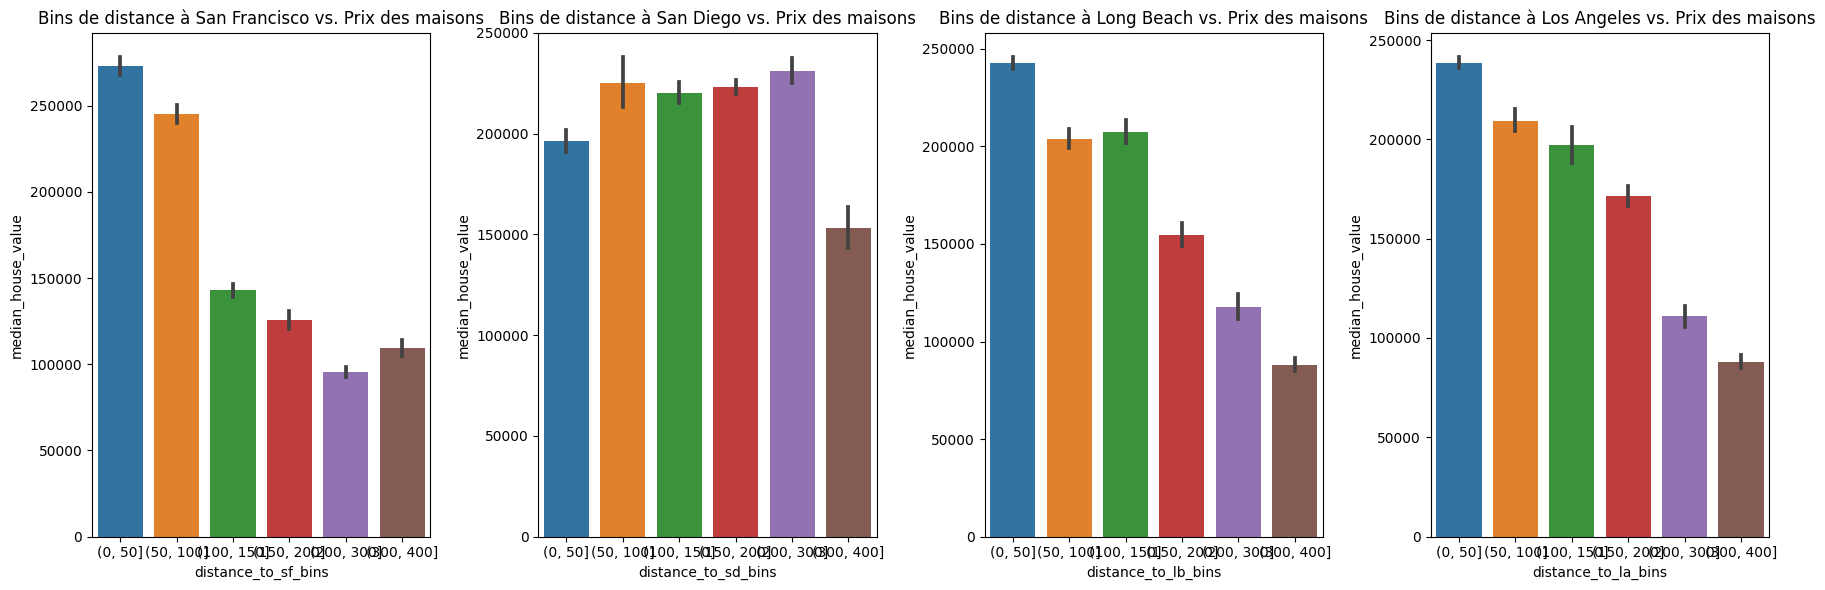

In [17]:
# Définir les bins pour toutes les distances à chaque ville
bins = [0, 50, 100,150,200,300,400]

# Regrouper les distances à chaque ville en utilisant les bins définis
df_clean['distance_to_sf_bins'] = pd.cut(df_clean['distance_to_sf'], bins=bins)
df_clean['distance_to_sd_bins'] = pd.cut(df_clean['distance_to_sd'], bins=bins)
df_clean['distance_to_lb_bins'] = pd.cut(df_clean['distance_to_lb'], bins=bins)
df_clean['distance_to_la_bins'] = pd.cut(df_clean['distance_to_la'], bins=bins)

# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Afficher le prix des maisons en fonction des bins de distance à San Francisco (bar plot)
sns.barplot(x='distance_to_sf_bins', y='median_house_value', data=df_clean, ax=axes[0])
axes[0].set_title('Bins de distance à San Francisco vs. Prix des maisons')

# Afficher le prix des maisons en fonction des bins de distance à San Diego (bar plot)
sns.barplot(x='distance_to_sd_bins', y='median_house_value', data=df_clean, ax=axes[1])
axes[1].set_title('Bins de distance à San Diego vs. Prix des maisons')

# Afficher le prix des maisons en fonction des bins de distance à Long Beach (bar plot)
sns.barplot(x='distance_to_lb_bins', y='median_house_value', data=df_clean, ax=axes[2])
axes[2].set_title('Bins de distance à Long Beach vs. Prix des maisons')

# Afficher le prix des maisons en fonction des bins de distance à Los Angeles (bar plot)
sns.barplot(x='distance_to_la_bins', y='median_house_value', data=df_clean, ax=axes[3])
axes[3].set_title('Bins de distance à Los Angeles vs. Prix des maisons')


plt.tight_layout()
plt.show()
df_clean.drop(['distance_to_sf_bins', 'distance_to_sd_bins', 'distance_to_lb_bins', 'distance_to_la_bins'], axis=1, inplace=True)

In [18]:
# Supposons que votre DataFrame s'appelle df et que vous avez déjà calculé les distances à chaque ville

# Définir les seuils de distance pour chaque ville
seuil_sf = 100  # Seuil pour San Francisco (100 km)
seuil_lb = 200  # Seuil pour Long Beach (200 km)
seuil_la = 200  # Seuil pour Los Angeles (200 km)
seuil_sd = 300  # Seuil pour San Diego (300 km)

# Créer une colonne centre_ville
df_clean['centre_ville'] = 0

# Mettre à jour la colonne centre_ville
df_clean.loc[(df_clean['distance_to_sf'] < seuil_sf) | 
       (df_clean['distance_to_lb'] < seuil_lb) | 
       (df_clean['distance_to_la'] < seuil_la) | 
       (df_clean['distance_to_sd'] < seuil_sd), 'centre_ville'] = 1
